In [9]:
# Import all modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
import torch
from scipy.stats.stats import pearsonr      

In [10]:
## Load all the intermediate outputs of the network for faster computation

num_classes = 10 #    
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# x_train - training data(images), y_train - labels(digits)

with open("../output/weight_matrix_Cifar.pkl", "rb") as input_file:
    [weight_matrix,y_predict] = pickle.load(input_file)
    
output_test = pickle.load(open('../data/output_test_cifar.pkl', 'rb'))
output_test_labels = np.argmax(output_test, axis=1)
output_train_labels = np.argmax(y_predict, axis=1)

with open('../data/intermediate34_train.pkl' , 'rb') as f:
    train_output34 = pickle.load(f)
    
with open('../data/intermediate34_test.pkl', 'rb') as f:
    test_output34 = pickle.load(f)
    
with open('../data/intermediate36_train.pkl' , 'rb') as f:
    train_output36 = pickle.load(f)
    
with open('../data/intermediate36_test.pkl', 'rb') as f:
    test_output36 = pickle.load(f)
    
with open('../data/presoft_test.pkl', 'rb') as f:
    presoft_test = pickle.load(f)
    
with open("../data/weight_323436.pkl", "rb") as input_file:
    [W_32,W_34,W_36,intermediate_output_32,intermediate_output_34,intermediate_output_36] = pickle.load(input_file)

print(intermediate_output_34.shape)
print(train_output34.shape)
print(intermediate_output_34[:5,:10])
print(train_output34[:5,:10])
print(intermediate_output_32[:5,:10])
print(intermediate_output_36[:5,:10])
print(np.sum(np.abs(intermediate_output_34-train_output34)))
    
def compute_pearson(x, y):
    numer = np.sum((x - np.mean(x)) * (y - np.mean(y)))
    denom = np.sqrt(np.sum((x - np.mean(x)) ** 2)) * np.sqrt(np.sum((y - np.mean(y)) ** 2))
    return numer / denom


(50000, 4096)
(50000, 4096)
[[0.13492662 0.         0.         0.         0.         0.
  0.42842513 0.         0.         0.        ]
 [1.8075626  0.         0.         0.         0.         0.
  0.         0.         2.6862917  0.        ]
 [0.41867277 0.         0.         0.         0.         0.37977907
  1.4116126  0.         1.2105861  0.13312808]
 [0.         0.         0.         0.30480152 0.         0.
  1.2458911  0.         0.37257743 0.        ]
 [0.         0.         0.         0.         0.46809822 1.4168749
  0.         0.         0.         0.        ]]
[[0.13492662 0.         0.         0.         0.         0.
  0.42842513 0.         0.         0.        ]
 [1.8075626  0.         0.         0.         0.         0.
  0.         0.         2.6862917  0.        ]
 [0.41867277 0.         0.         0.         0.         0.37977907
  1.4116126  0.         1.2105861  0.13312808]
 [0.         0.         0.         0.30480152 0.         0.
  1.2458911  0.         0.372577

In [11]:
# calculation for softmax in torch, which avoids numerical overflow
N = 50000
def softmax_torch(temp,N):
    max_value,_ = torch.max(temp,1,keepdim = True)
    temp = temp-max_value
    D_exp = torch.exp(temp)
    D_exp_sum = torch.sum(D_exp, dim=1).view(N,1)
    return D_exp.div(D_exp_sum.expand_as(D_exp))

## Calculate correlations and mean differences for training and testing

tensor_train34 = torch.FloatTensor(train_output34)
tensor_test34 = torch.FloatTensor(test_output34)

w_tensor = torch.FloatTensor(weight_matrix)
prod_train = torch.matmul(torch.t(tensor_train34),w_tensor)
prod_train_test = torch.matmul(tensor_test34.cuda(), prod_train.cuda())
prod_train_train = torch.matmul(tensor_train34.cuda(), prod_train.cuda())

prod_train_test = prod_train_test - torch.max(prod_train_test,1,True)[0]
prod_train_train = prod_train_train - torch.max(prod_train_train,1,True)[0]

D_exp_train_test = torch.exp(prod_train_test)
D_exp_sum_train_test = torch.sum(D_exp_train_test, dim=1).view(10000,1)

D_exp_train_train = torch.exp(prod_train_train)
D_exp_sum_train_train = torch.sum(D_exp_train_train, dim=1).view(50000,1)

## new code for calculation
w_tensor = torch.FloatTensor(weight_matrix)
print(w_tensor[:5,:5])
prod_train = torch.matmul(torch.t(tensor_train34),w_tensor)
print(prod_train[:5,:5])
prod_train_test = torch.matmul(tensor_test34.cuda(), prod_train.cuda())
prod_train_train = torch.matmul(tensor_train34.cuda(), prod_train.cuda())
print(prod_train_train[:5,:5])
softmax_value_test = softmax_torch(prod_train_test,10000)
softmax_value_train = softmax_torch(prod_train_train,50000)
y_p_test = softmax_value_test.cpu().numpy()
y_p_train = softmax_value_train.cpu().numpy()

print(y_p_train[:5,:])

#y_p_train_train = D_exp_train_train.div(D_exp_sum_train_train.expand_as(D_exp_train_train))
#y_p_train = y_p_train_train.cpu().numpy()

#y_p_train_test = D_exp_train_test.div(D_exp_sum_train_test.expand_as(D_exp_train_test))
#y_p_test = y_p_train_test.cpu().numpy()

Y_test = test_output36 
Y_train = train_output36
print('Absolute Mean Diff: {}, {}'.format(np.mean(np.abs(Y_train-y_p_train)), np.mean(np.abs(Y_test-y_p_test))))
corr_train,_ = (pearsonr((Y_train).flatten(),(y_p_train).flatten()))
corr_test,_ = (pearsonr((Y_test).flatten(),(y_p_test).flatten()))
print('Correlations: {}, {}'.format(corr_train, corr_test))


tensor([[-0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000]])
tensor([[-0.0043, -0.0093, -0.0038,  0.0104, -0.0051],
        [-0.0023, -0.0022, -0.0016,  0.0036, -0.0023],
        [ 0.0170, -0.0034, -0.0012,  0.0161, -0.0073],
        [-0.0011, -0.0008, -0.0021, -0.0060,  0.0029],
        [ 0.0194, -0.0072, -0.0150, -0.0048, -0.0129]])
tensor([[-4.8253, -1.3008,  0.7335,  1.9261, -0.9136],
        [ 0.1585,  1.1508, -3.3137, -2.4110, -2.8491],
        [ 0.8607, -0.2165, -3.5193, -2.8176, -2.8669],
        [-2.6568, -3.1734, -2.4276, -1.4150, 14.1943],
        [-0.7527, 20.5090, -4.6449, -2.9848, -4.7669]], device='cuda:0')
[[1.6236372e-07 5.5100104e-06 4.2136286e-05 1.3886324e-04 8.1154276e-06
  5.3274653e-05 9.9974436e-01 3.8895283e-07 3.3364940e-06 3.9166061e-06]
 [9.379120

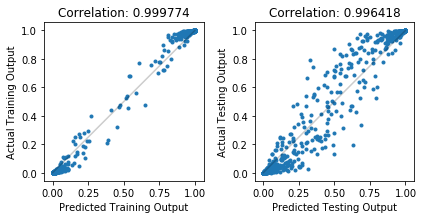

In [13]:
## Plot subset of the data

np.random.seed(401)
train_rand_idx = np.random.choice(50000, 2000, replace=False)
np.random.seed(4)
test_rand_idx = np.random.choice(10000, 1000, replace=False)

corr_train_part,_ = (pearsonr((Y_train[train_rand_idx]).flatten(),(y_p_train[train_rand_idx]).flatten()))
corr_test_part,_ = (pearsonr((Y_test[test_rand_idx]).flatten(),(y_p_test[test_rand_idx]).flatten()))

fig, ax = plt.subplots(1,2)

ax[0].scatter(y_p_train[train_rand_idx], Y_train[train_rand_idx], marker='.')
ax[0].plot([0, 1], [0, 1], 'k-', alpha=0.2, zorder=1)
ax[0].set_title('Correlation: %f'%corr_train_part)
ax[0].set_xlabel('Predicted Training Output')
ax[0].set_ylabel('Actual Training Output')
ax[0].set_aspect('equal')

ax[1].scatter(y_p_test[test_rand_idx], Y_test[test_rand_idx], marker='.')
ax[1].plot([0, 1], [0, 1], 'k-', alpha=0.2, zorder=1)
ax[1].set_title('Correlation: %f'%corr_test_part)
ax[1].set_xlabel('Predicted Testing Output')
ax[1].set_ylabel('Actual Testing Output')
ax[1].set_aspect('equal')
plt.tight_layout()
plt.savefig('correlation.png', dpi=200)